In [1]:
import pandas as pd

from importlib.machinery import SourceFileLoader
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

DI = SourceFileLoader("DI", "src/DI.py").load_module()

Handler = DI.Handler.Handler()
Graph = DI.Graph.Graph()
AlgoML = DI.AlgoML.AlgoML()
Refine = DI.Refine.Refine()

_data_train = pd.read_csv("/home/agl/codenation/20200606_DS_codenationModule9/1.Original/train.csv")
_data_test = pd.read_csv("/home/agl/codenation/20200606_DS_codenationModule9/1.Original/test.csv")

print(f"shape train --> {_data_train.shape} \t shape test --> {_data_test.shape}")

shape train --> (13730, 167) 	 shape test --> (4570, 43)


In [70]:
#who are our object into dataframe? should us care about them?
_data_train.dtypes[_data_train.dtypes == "object"]

NU_INSCRICAO                   object
NO_MUNICIPIO_RESIDENCIA        object
SG_UF_RESIDENCIA               object
TP_SEXO                        object
NO_MUNICIPIO_NASCIMENTO        object
SG_UF_NASCIMENTO               object
NO_MUNICIPIO_ESC               object
SG_UF_ESC                      object
NO_ENTIDADE_CERTIFICACAO       object
SG_UF_ENTIDADE_CERTIFICACAO    object
NO_MUNICIPIO_PROVA             object
SG_UF_PROVA                    object
CO_PROVA_CN                    object
CO_PROVA_CH                    object
CO_PROVA_LC                    object
CO_PROVA_MT                    object
TX_RESPOSTAS_CN                object
TX_RESPOSTAS_CH                object
TX_RESPOSTAS_LC                object
TX_RESPOSTAS_MT                object
TX_GABARITO_CN                 object
TX_GABARITO_CH                 object
TX_GABARITO_LC                 object
TX_GABARITO_MT                 object
Q001                           object
Q002                           object
Q003        

In [2]:
corr_mat = _data_train.corr()["IN_TREINEIRO"]
columns_corr_mat = corr_mat[(corr_mat > 0.4) | (corr_mat < -0.2)]
columns_corr_mat

NU_IDADE          -0.295091
TP_ST_CONCLUSAO    0.533983
TP_ANO_CONCLUIU   -0.257710
TP_ESCOLA         -0.244562
IN_TREINEIRO       1.000000
Name: IN_TREINEIRO, dtype: float64

In [3]:
#see which of columns above also are on dataset of test
names_columns_corr_mat = columns_corr_mat.index

set(names_columns_corr_mat).intersection(set(_data_test.columns))

{'NU_IDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ST_CONCLUSAO'}

In [4]:
_data_train[names_columns_corr_mat].isna().sum()

NU_IDADE           0
TP_ST_CONCLUSAO    0
TP_ANO_CONCLUIU    0
TP_ESCOLA          0
IN_TREINEIRO       0
dtype: int64

In [13]:
_data_train[names_columns_corr_mat].dtypes

NU_IDADE           int64
TP_ST_CONCLUSAO    int64
TP_ANO_CONCLUIU    int64
TP_ESCOLA          int64
IN_TREINEIRO       int64
dtype: object

In [20]:
set_train = set(_data_train[names_columns_corr_mat])
#4 is the index of IN_TREINEIRO, which we can assume that not should is on data test
set_test = set(_data_test[names_columns_corr_mat.delete(4)])

features = list(set_train.intersection(set_test))

print(f"The useful variable are: \n\n{features}")

The useful variable are: 

['TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'NU_IDADE']


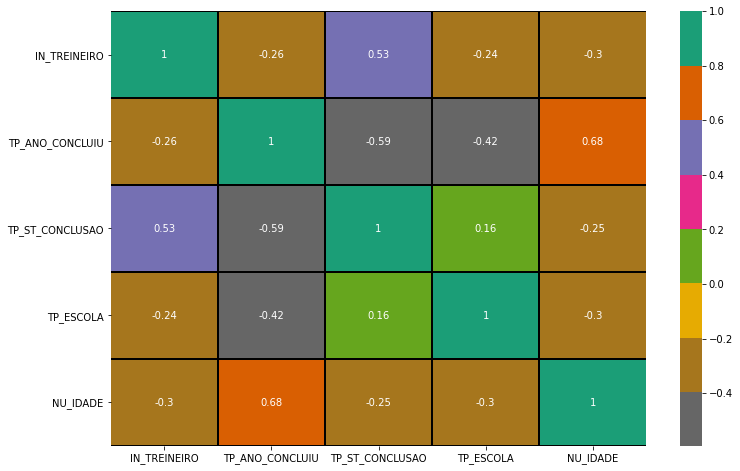

In [21]:
heatmap_features = ["IN_TREINEIRO"] + features
plt.subplots(figsize=(12, 8))
sns.heatmap(_data_train[heatmap_features].corr(), annot=True, cmap="Dark2_r", linewidths=0.5, linecolor="Black")

In [22]:
_data_train[heatmap_features].describe()
#std of NU_NOTA_REDACAO is the biggest, maybe could be a good option discretize it in quantile?

,IN_TREINEIRO,TP_ANO_CONCLUIU,TP_ST_CONCLUSAO,TP_ESCOLA,NU_IDADE
count,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000
mean,0.129862,2.146176,1.782666,1.353532,21.593809
std,0.336163,3.217328,0.880734,0.558472,7.043654
min,0.000000,0.000000,1.000000,1.000000,13.000000
25%,0.000000,0.000000,1.000000,1.000000,17.000000
50%,0.000000,0.000000,2.000000,1.000000,19.000000
75%,0.000000,3.000000,2.000000,2.000000,23.000000
max,1.000000,10.000000,4.000000,4.000000,67.000000


In [26]:
dth = _data_train[heatmap_features]
dth.head(6)

,IN_TREINEIRO,TP_ANO_CONCLUIU,TP_ST_CONCLUSAO,TP_ESCOLA,NU_IDADE
0,0,4,1,1,24
1,0,0,2,2,17
2,0,0,3,1,21
3,0,9,1,1,25
4,0,4,1,1,28
5,0,1,1,1,18


# DICT

### TP_ST_CONCLUSAO

1	Já concluí o Ensino Médio

2	Estou cursando e concluirei o Ensino Médio em 2016

3	Estou cursando e concluirei o Ensino Médio após 2016

4	Não concluí e não estou cursando o Ensino Médio

### TP_ANO_CONCLUIU

0	Não informado

1	2015

2	2014

3	2013

4	2012

5	2011

6	2010

7	2009

8	2008

9	2007

10	Anterior a 2007

### TP_ESCOLA

1	Não Respondeu

2	Pública

3	Privada

4	Exterior

In [31]:
dth["TP_ESCOLA"].unique()

array([1, 2, 3, 4])

In [25]:
train_imputed = _data_train[heatmap_features]
train_imputed = pd.DataFrame(Refine.imputer_na(train_imputed, "median"), columns=train_imputed.columns)

train_imputed_standard = Refine.standardize(train_imputed).transform(train_imputed)
train_imputed_standard = pd.DataFrame(train_imputed_standard, columns=train_imputed.columns)

train_imputed_normalized = Refine.normalize(train_imputed).transform(train_imputed)
train_imputed_normalized = pd.DataFrame(train_imputed_normalized, columns=train_imputed.columns)

features_rfe = Handler.RFE(train_imputed, "IN_TREINEIRO", 7)
print(f"PCA 90% obtido features_imputed: \n {Handler.PCA(train_imputed, 0.90)}\n RFE de 7 features:\n{features_rfe[0][0:]}")

features_standard_rfe = Handler.RFE(train_imputed_standard, "IN_TREINEIRO", 10)
print(f"\nPCA 90% features_standard: \n {Handler.PCA(train_imputed_standard, 0.90)}\n RFE de 10 features:\n{features_standard_rfe[0][0:]}")

features_normalized_rfe = Handler.RFE(train_imputed_normalized, "IN_TREINEIRO", 10)
print(f"\nPCA 90% features_normalized: \n {Handler.PCA(train_imputed_normalized, 0.90)}\n RFE de 10 features:\n{features_normalized_rfe[0][0:]}")

PCA 90% obtido features_imputed: 
 1
 RFE de 7 features:
['TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'NU_IDADE']

PCA 90% features_standard: 
 4
 RFE de 10 features:
['TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'NU_IDADE']

PCA 90% features_normalized: 
 3
 RFE de 10 features:
['TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'NU_IDADE']
